# Neural Networks in more details

Based on [cs231](http://cs231n.github.io/) by Stanford

In [1]:
# No Keras! No Pytorch!
# We will use Numpy :))

import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

## Recall the problem

### Moon data with Train/Test split

In [3]:
import sklearn.datasets

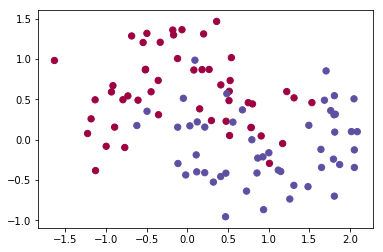

In [4]:
# Generate a dataset and plot it
X, y = sklearn.datasets.make_moons(100, shuffle=False, noise=0.35, random_state=42)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

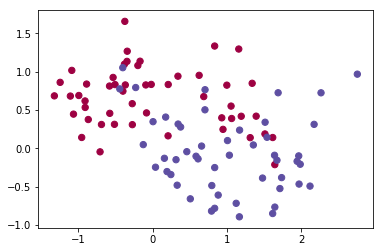

In [5]:
X_test, y_test = sklearn.datasets.make_moons(100, shuffle=False, noise=0.35, random_state=0)
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, cmap=plt.cm.Spectral)

## Third attempt: Cross-entropy loss and softmax

### Softmax Function

Softmax function takes an N-dimensional vector of real numbers and transforms it into a vector of real number in range (0,1) which add upto 1

<img src="https://eli.thegreenplace.net/images/2016/softmax-layer-generic.png" alt="Softmax" style="width: 50%"/>



$$p_k = \dfrac{e^{f_k}}{\sum_{j} e^{f_j}}$$


Applying **Bayes' rule** gives us the softmax function as a natural representation for the posterior distribution in a multi-class classification problem.:

$$% <![CDATA[
\begin{eqnarray}
p(w_i | x) & = & \frac{p(x|w_i) p(w_i)}{p(x)} \\
 & = & \frac{p(x|w_i) p(w_i)}{\sum_j p(x|w_j) p(w_j)} \\
 & = & \frac{exp(log(p(x|w_i) p(w_i)))}{\sum_j exp(log(p(x|w_j) p(w_j)))} \\
 & = & \frac{e^{f_i (x)}}{\sum_j e^{f_j (x)}}
\end{eqnarray} %]]>$$



### Cross-entropy loss

Cross entropy indicates the distance between what the model believes the output distribution should be, and what the original distribution really is. It is defined as:

$$H(y,p) = - \sum_i y_i log(p_i)$$



*Negative Log-Likelihood* (NLL): 

<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log.png" alt="Softmax" style="width: 40%"/>




$$L(\mathbf{y}) = -\log(\mathbf{y})$$


<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log_demo.png" alt="Softmax" style="width: 90%"/>

Let's take its **derivative**:

$$% <![CDATA[
\dfrac{\partial L_i}{\partial f_k} = \dfrac{\partial L_i}{\partial p_k} \dfrac{\partial p_k}{\partial f_k}$$
$$\dfrac{\partial L_i}{\partial p_k} = -\dfrac{1}{p_k}$$


Derivative of **softmax**:

let's $\Sigma = \sum_{j} e^{f_j}$

$$
\begin{eqnarray}
\dfrac{\partial p_k}{\partial f_k} &=& \dfrac{\partial}{\partial f_k} \left(\dfrac{e^{f_k}}{\sum_{j} e^{f_j}}\right) \\
&=& \dfrac{\Sigma \mathbf{D} e^{f_k} - e^{f_k} \mathbf{D} \Sigma}{\Sigma^2} \\
&=& \dfrac{e^{f_k}(\Sigma - e^{f_k})}{\Sigma^2}&=& \dfrac{e^{f_k}}{\Sigma} \dfrac{\Sigma - e^{f_k}}{\Sigma} \\
&=& p_k * (1-p_k)
\end{eqnarray}$$


By combining the two derivatives, we have:

$$% <![CDATA[
\begin{eqnarray}
\dfrac{\partial L_i}{\partial f_k} &=& \dfrac{\partial L_i}{\partial p_k} \dfrac{\partial p_k}{\partial f_k} \\
&=& -\dfrac{1}{p_k} (p_k * (1-p_k)) \\
&=& (p_k - 1)
\end{eqnarray} %]]>$$

Total loss is then defined as the average NLL over the training examples and the regularization:

$$L=\underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss}$$

In [6]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes

In [7]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(dA, Z):
    return dA * Z * (1 - Z)


def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;


In [8]:
# Helper function to predict an output (0 or 1)
def predict(W, b, x):
    hidden_layer = np.maximum(0, np.dot(x, W[0]) + b[0])
    scores = np.dot(hidden_layer, W[1]) + b[1]
    return np.argmax(scores, axis=1)

In [14]:
# initialize parameters randomly
h = 50 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))


# some hyperparameters
step_size = 0.5
reg = 0.0 # regularization strength
dropout = 0

# gradient descent loop
num_examples = X.shape[0]
for i in range(8100):

    # evaluate class scores, [N x K]
    hidden_layer = relu(np.dot(X, W) + b) # note, ReLU activation
    if dropout > 0:
        U1 = (np.random.rand(*hidden_layer.shape) < dropout) / dropout # first dropout mask. Notice /p!
        hidden_layer *= U1 # drop!
    
    scores = np.dot(hidden_layer, W2) + b2

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss
    if i % 1000 == 0:
        print("iteration %d: loss %f | train accuracy %f  | test accuracy %f" % (
                i,
                loss,
                (np.mean(predict((W, W2), (b, b2), X) == y)),
                (np.mean(predict((W, W2), (b, b2), X_test) == y_test))
             ))
        

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden = relu_backward(dhidden, hidden_layer)
    
    if dropout > 0:
        dhidden *= U1 # drop!
        dhidden = dhidden / dropout
    
    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 0.693072 | train accuracy 0.610000  | test accuracy 0.620000
iteration 1000: loss 0.286311 | train accuracy 0.870000  | test accuracy 0.860000
iteration 2000: loss 0.275482 | train accuracy 0.860000  | test accuracy 0.830000
iteration 3000: loss 0.269559 | train accuracy 0.890000  | test accuracy 0.840000
iteration 4000: loss 0.271872 | train accuracy 0.860000  | test accuracy 0.830000
iteration 5000: loss 0.271592 | train accuracy 0.860000  | test accuracy 0.830000
iteration 6000: loss 0.272287 | train accuracy 0.860000  | test accuracy 0.830000
iteration 7000: loss 0.271684 | train accuracy 0.860000  | test accuracy 0.830000
iteration 8000: loss 0.271465 | train accuracy 0.860000  | test accuracy 0.830000


In [15]:
 predict((W, W2), (b, b2), X)

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
def plot_decision_boundary(X, y, pred_func):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

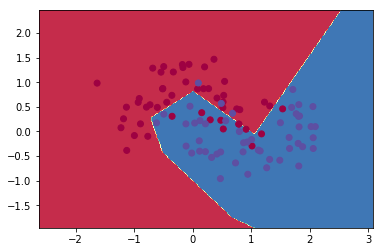

In [17]:
plot_decision_boundary(X, y, lambda x: predict((W, W2), (b, b2), x))

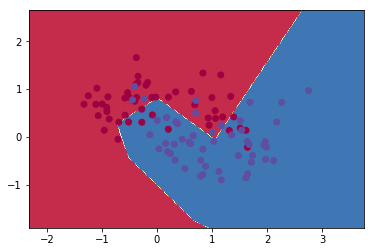

In [18]:
plot_decision_boundary(X_test, y_test, lambda x: predict((W, W2), (b, b2), x))

Check [online demo by Stanford](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)

### Activations

<img src="https://miro.medium.com/max/2384/1*4ZEDRpFuCIpUjNgjDdT2Lg.png" alt="Activations" style="width: 80%"/>


Check more functions here - https://mlfromscratch.com/activation-functions-explained/#/

*TLDR*: “What neuron type should I use?” Use the **ReLU** non-linearity, be careful with your learning rates and possibly monitor the fraction of “dead” units in a network. If this concerns you, try **Leaky ReLU**/**ELU**/**SELU**. Never use sigmoid.


### Data Preprocessing

* Mean subtraction
* Normalization
* PCA and Whitening


<img src="http://cs231n.github.io/assets/nn2/prepro1.jpeg" alt="Normalization" style="width: 80%"/>
<img src="http://cs231n.github.io/assets/nn2/prepro2.jpeg" alt="PCA and Whitening" style="width: 80%"/>


### Regularizaion

* L1/L2 regularization
* Dropout
* Augmentations

<img src="http://cs231n.github.io/assets/nn2/dropout.jpeg" alt="Dropout" style="width: 50%"/>

### Parameter updates

Introduce **Momentum**: 

```python
# Momentum update
v = mu * v - learning_rate * dx # integrate velocity
x += v # integrate position```


<img src="http://cs231n.github.io/assets/nn3/nesterov.jpeg" alt="Optimization1" style="width: 80%;"/>


Popular optimizers:
* **Nesterov’s Accelerated Momentum (NAG)** - SGD + Nesterov's Momentum
* **Adagrad** - weights that receive high gradients will have their effective learning rate reduced, while weights that receive small or infrequent updates will have their effective learning rate increased
* **RMSprop** - RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate 
* **ADAM** - **the default algorithm** to use, and often works slightly better than RMSProp. However, it is often also worth trying SGD+Nesterov Momentum as an alternative. The full Adam update also includes a bias correction mechanism, which compensates for the fact that in the first few time steps the vectors *m*, *v* are both initialized and therefore biased at zero, before they fully “warm up”

<img src="http://cs231n.github.io/assets/nn3/opt2.gif" alt="Optimization1" style="width: 50%;"/>
<img src="http://cs231n.github.io/assets/nn3/opt1.gif" alt="Optimization2" style="width: 50%;"/>

Read more about optimizers here - http://cs231n.github.io/neural-networks-3/

Check more about dynamic learning rate here -  https://www.jeremyjordan.me/nn-learning-rate/

 ## All together: MNIST classifier

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 0.4.1  Device: cpu


In [37]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

In [38]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


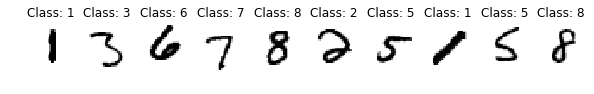

In [39]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # map [batch_size, 1, 28, 28] -> [batch_size, 784]
        x = F.elu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.elu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [41]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    train_loss, correct = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)
        
        train_loss += loss.data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            
    train_loss /= len(train_loader)
    accuracy = 100. * correct.to(torch.float32) / len(train_loader.dataset)
    
    return train_loss, accuracy

In [42]:
def validate():
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    
    return val_loss, accuracy

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    train_loss, accuracy = train(epoch)
    lossv.append(train_loss)
    accv.append(accuracy)    
    
    val_loss, val_accuracy = validate()
    val_lossv.append(val_loss)
    val_accv.append(val_accuracy)
    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        train_loss, accuracy))
    print('Validation set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        val_loss, val_accuracy))

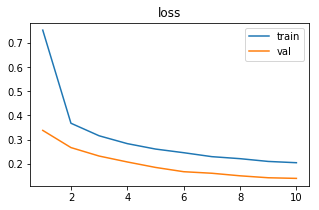

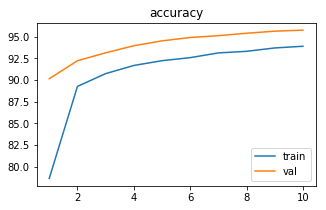

In [44]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='train')
plt.plot(np.arange(1,epochs+1), val_lossv, label='val')
plt.title('loss')
plt.legend()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv, label='train')
plt.plot(np.arange(1,epochs+1), val_accv, label='val')
plt.title('accuracy');
plt.legend()

In [45]:
dataiter = iter(validation_loader)

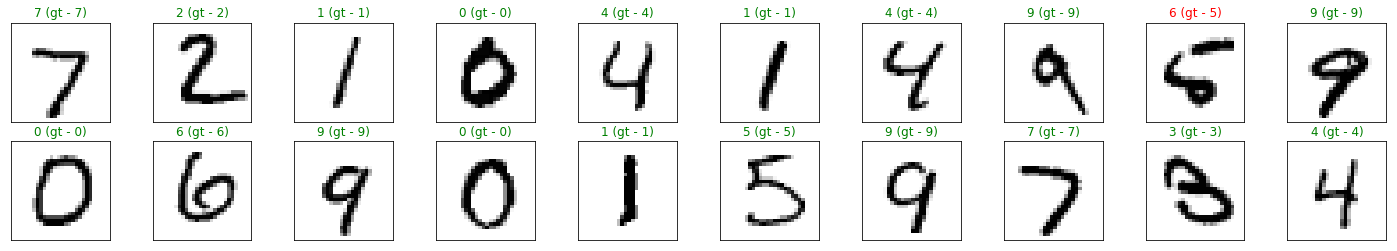

In [46]:

images, labels = dataiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
    ax.set_title("{} (gt - {})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

---

##  -- Homework --

1. Log training history in order to visualize different experiments on the same graph
2. Try to improve model accurracy and training time
    * introduce learning rate scheduler
    * try other optimizers
    * try other weight initialization (http://cs231n.github.io/neural-networks-2/)



---

## Sources

* [cs231](http://cs231n.github.io/) by Stanford
* [https://deepnotes.io/softmax-crossentropy](https://deepnotes.io/softmax-crossentropy)
* [Why the Softmax Function?](https://crazyoscarchang.github.io/2018/08/29/why-the-softmax-function/)
* [Softmax and NLL](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)